# Trader Behavior – Advanced Modeling & Visualization Notebook
Includes:
- Extensive Sentiment-Based Visual Analysis
- Logistic Regression
- Decision Tree
- K-Means Clustering
- Clean, single-plot-per-figure formatting

## 1. Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler

## 2. Load & Prepare Data

In [2]:
fear_greed = pd.read_csv('fear_greed_index.csv')
trades = pd.read_csv('historical_data.csv')

In [3]:
fear_greed['date'] = pd.to_datetime(fear_greed['date'])
trades['Timestamp'] = pd.to_datetime(trades['Timestamp'], unit='ms')

trades['date'] = trades['Timestamp'].dt.date
fear_greed['date_only'] = fear_greed['date'].dt.date

merged = trades.merge(
    fear_greed[['date_only','classification']],
    left_on='date', right_on='date_only',
    how='inner'
)

merged['Closed PnL'] = pd.to_numeric(merged['Closed PnL'], errors='coerce')
merged['Size USD'] = pd.to_numeric(merged['Size USD'], errors='coerce')

print('Merged Shape:', merged.shape)

Merged Shape: (184263, 19)


## 3. Sentiment Distribution

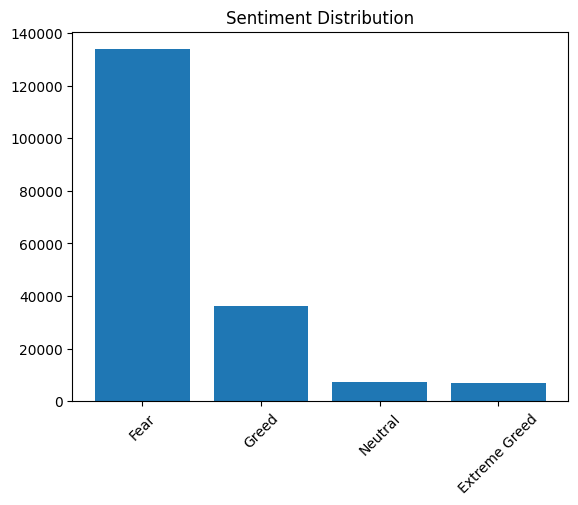

In [4]:
counts = merged['classification'].value_counts()
plt.figure()
plt.bar(counts.index, counts.values)
plt.title('Sentiment Distribution')
plt.xticks(rotation=45)
plt.show()

## 4. Average Trade Size by Sentiment

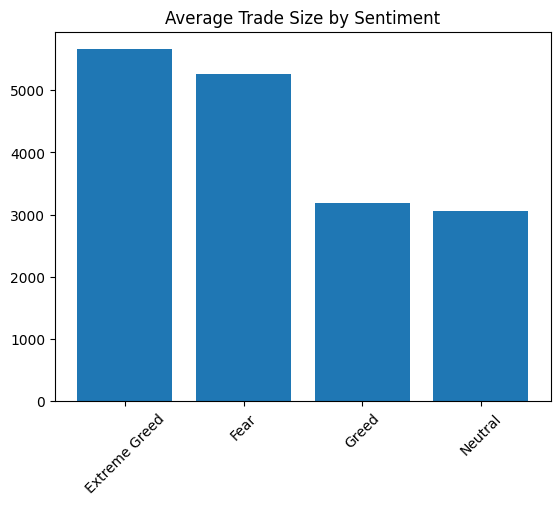

In [5]:
avg_size = merged.groupby('classification')['Size USD'].mean()
plt.figure()
plt.bar(avg_size.index, avg_size.values)
plt.title('Average Trade Size by Sentiment')
plt.xticks(rotation=45)
plt.show()

## 5. Win Rate by Sentiment

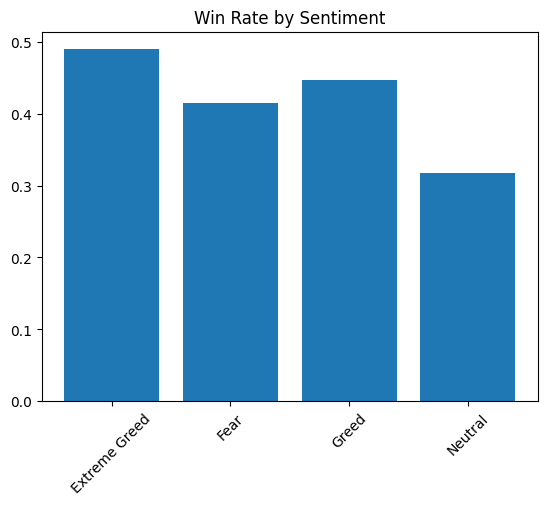

In [6]:
merged['win'] = (merged['Closed PnL'] > 0).astype(int)
win_rate = merged.groupby('classification')['win'].mean()

plt.figure()
plt.bar(win_rate.index, win_rate.values)
plt.title('Win Rate by Sentiment')
plt.xticks(rotation=45)
plt.show()

## 6. Total PnL by Sentiment

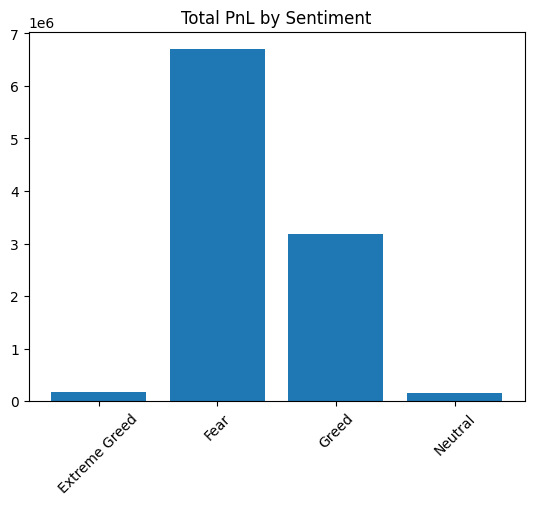

In [7]:
pnl_sum = merged.groupby('classification')['Closed PnL'].sum()

plt.figure()
plt.bar(pnl_sum.index, pnl_sum.values)
plt.title('Total PnL by Sentiment')
plt.xticks(rotation=45)
plt.show()

## 7. Distribution of Trade Sizes

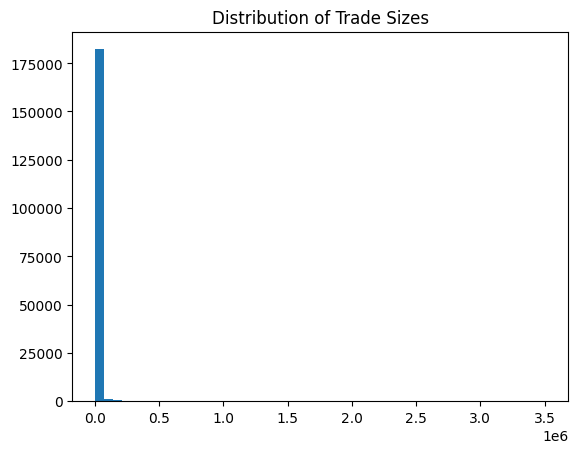

In [8]:
plt.figure()
plt.hist(merged['Size USD'], bins=50)
plt.title('Distribution of Trade Sizes')
plt.show()

## 8. Distribution of Closed PnL

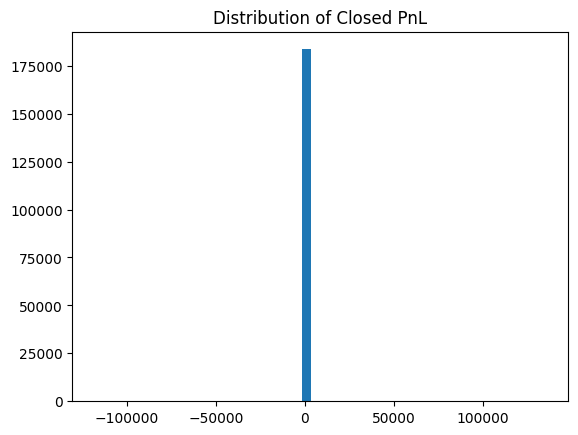

In [9]:
plt.figure()
plt.hist(merged['Closed PnL'], bins=50)
plt.title('Distribution of Closed PnL')
plt.show()

## 9. Boxplot: PnL by Sentiment

<Figure size 640x480 with 0 Axes>

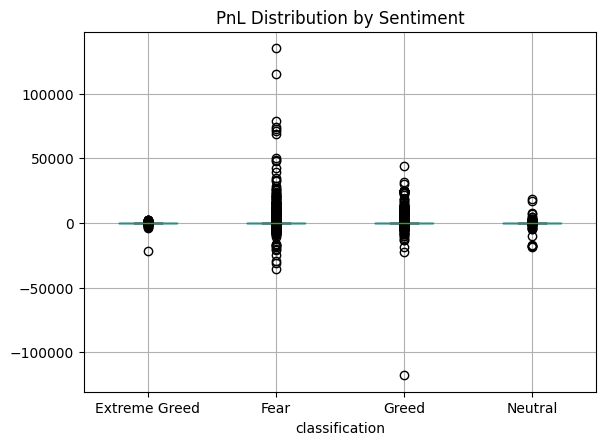

In [10]:
plt.figure()
merged.boxplot(column='Closed PnL', by='classification')
plt.title('PnL Distribution by Sentiment')
plt.suptitle('')
plt.show()

## 10. Logistic Regression

In [11]:
merged['target'] = (merged['Closed PnL'] > 0).astype(int)
model_df = pd.get_dummies(merged, columns=['classification'], drop_first=True)

features = ['Size USD'] + [c for c in model_df.columns if c.startswith('classification_')]

X = model_df[features].fillna(0)
y = model_df['target']

In [12]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42
)

In [13]:
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train, y_train)

y_pred = log_model.predict(X_test)

print('Accuracy:', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.5771088478445703
              precision    recall  f1-score   support

           0       0.58      1.00      0.73     31902
           1       0.00      0.00      0.00     23377

    accuracy                           0.58     55279
   macro avg       0.29      0.50      0.37     55279
weighted avg       0.33      0.58      0.42     55279



c:\Python314\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Python314\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Python314\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


## 11. Decision Tree

In [14]:
tree = DecisionTreeClassifier(max_depth=5, min_samples_split=50, random_state=42)
tree.fit(X_train, y_train)

y_pred_tree = tree.predict(X_test)

print('Accuracy:', accuracy_score(y_test, y_pred_tree))
print(classification_report(y_test, y_pred_tree))

Accuracy: 0.5858825232004921
              precision    recall  f1-score   support

           0       0.59      0.96      0.73     31902
           1       0.58      0.08      0.13     23377

    accuracy                           0.59     55279
   macro avg       0.58      0.52      0.43     55279
weighted avg       0.58      0.59      0.48     55279



## 12. K-Means Clustering

In [15]:
trader_stats = merged.groupby('Account').agg(
    total_pnl=('Closed PnL','sum'),
    trades=('Closed PnL','count'),
    avg_size=('Size USD','mean')
).reset_index()

In [16]:
features_cluster = ['total_pnl','trades','avg_size']
scaler_cluster = StandardScaler()
X_cluster = scaler_cluster.fit_transform(trader_stats[features_cluster])

In [17]:
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
trader_stats['cluster'] = kmeans.fit_predict(X_cluster)

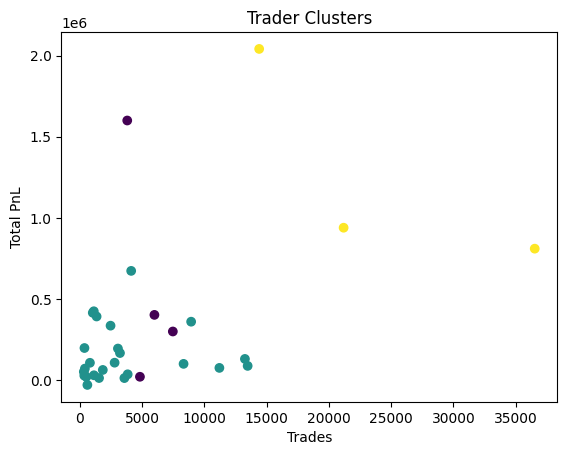

In [18]:
plt.figure()
plt.scatter(trader_stats['trades'], trader_stats['total_pnl'], c=trader_stats['cluster'])
plt.xlabel('Trades')
plt.ylabel('Total PnL')
plt.title('Trader Clusters')
plt.show()